# ¿How well does a metric learning approach do?

In [1]:
import torch
from functools import partial
import torch.nn as nn
from torchvision import transforms
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from tqdm import tqdm
import matplotlib.pyplot as plt


# reproducibility
seed = 1993
torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.cuda.manual_seed_all(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = 'cuda' if torch.cuda.is_available() else 'cpu'
data_dir = "./data"

## Load and preprocess data

In [2]:
train_dataset_gpu = {}
eval_dataset_gpu = {}

# dataset
train = torchvision.datasets.CIFAR100(root=data_dir, download=True, transform=transforms.ToTensor())
eval = torchvision.datasets.CIFAR100(root=data_dir, train=False, transform=transforms.ToTensor())

# move dataset to gpu
train_dataset_gpu_loader = torch.utils.data.DataLoader(train, batch_size=len(train), drop_last=True,
                                            shuffle=True, num_workers=2, persistent_workers=False)
eval_dataset_gpu_loader = torch.utils.data.DataLoader(eval, batch_size=len(eval), drop_last=True,
                                            shuffle=False, num_workers=1, persistent_workers=False)
train_dataset_gpu['images'], train_dataset_gpu['targets'] = [item.to(device="cuda", non_blocking=True) for item in next(iter(train_dataset_gpu_loader))]
eval_dataset_gpu['images'],  eval_dataset_gpu['targets']  = [item.to(device="cuda", non_blocking=True) for item in next(iter(eval_dataset_gpu_loader)) ]

# normalize images
train_cifar_std, train_cifar_mean = torch.std_mean(train_dataset_gpu['images'], dim=(0, 2, 3)) 
print(f"Mean: {[f'{x:.4f}' for x in train_cifar_mean.tolist()]}")
print(f"Std: {[f'{x:.4f}' for x in train_cifar_std.tolist()]}")
def batch_normalize_images(input_images, mean, std):
    return (input_images - mean.view(1, -1, 1, 1)) / std.view(1, -1, 1, 1)
batch_normalize_images = partial(batch_normalize_images, mean=train_cifar_mean, std=train_cifar_std)
train_dataset_gpu['images'] = batch_normalize_images(train_dataset_gpu['images'])
eval_dataset_gpu['images']  = batch_normalize_images(eval_dataset_gpu['images'])

data = {
        'train': train_dataset_gpu,
        'eval': eval_dataset_gpu
    }

# pad images for later random cropping
pad_amount = 4
data['train']['images'] = F.pad(data['train']['images'], (pad_amount,)*4, 'reflect')

Files already downloaded and verified
Mean: ['0.5071', '0.4865', '0.4409']
Std: ['0.2673', '0.2564', '0.2762']


### Metric based data loading

In [3]:
from batch_transforms import batch_crop, batch_flip_lr

@torch.no_grad()
def get_batches(data_dict, key, batchsize, indices=range(100)):
    # select subset of class indices 
    indices = torch.tensor(indices, device=device)
    images, targets = data_dict[key]["images"], data_dict[key]["targets"] 
    samples = torch.isin(targets, indices)
    images, targets = images[samples], targets[samples]
    
    assert len(images) == len(targets)

    # as we are going to pair up the images, we need the size of the dataset to be even
    if len(images) % 2 != 0:
        images = images[:-1]
        targets = targets[:-1]

    num_epoch_examples = len(images)
    shuffled = torch.randperm(num_epoch_examples, device=device)
    crop_size = 32

    # shuffle the dataset
    images = images[shuffled]
    targets = targets[shuffled]

    # transforms
    if key == 'train':
        images = batch_crop(images, crop_size)
        images = batch_flip_lr(images)

    # pair up the dataset
    targets = targets.reshape(num_epoch_examples // 2, 2)
    binary_targets = torch.eq(targets[:,0], targets[:,1])
    # we need that roughly 50% of the pairs are positive and negative
    while binary_targets.float().mean() < 0.5:
        # unpair the target and binary_targets
        targets = targets.reshape(num_epoch_examples)  
        binary_targets = torch.stack([binary_targets, binary_targets], 1).reshape(num_epoch_examples)
        # get negative elements from negative pairs
        neg = binary_targets == False
        # permute them hoping some of them turn into positive pairs
        perm = torch.randperm(len(binary_targets[neg]))
        images[neg] = images[neg][perm]
        targets[neg] = targets[neg][perm]
        # re-pair the targets
        targets = targets.reshape(num_epoch_examples // 2, 2)
        binary_targets = torch.eq(targets[:,0], targets[:,1])
    ## TODO: ensuring 50% distribtution takes much longer than before 
    ## without 50% -> 30 ms
    ## with 50% -> 1 seg
    
    images = images.reshape(num_epoch_examples // 2, 2, 3, images.shape[-1], images.shape[-2])
    num_epoch_examples = len(images)

    for idx in range(num_epoch_examples // batchsize):
        yield images[idx*batchsize: (idx+1)*batchsize], targets[idx*batchsize: (idx+1)*batchsize]

#### ¿How do I make sure that the implementation is correct?

- ¿Are there any duplicated or overlapping pairs?
    I think there are not since the pairs are selected by reshaping the original 1d-tensor of targets in a matrix with 2 rows, so if there were not any duplicates in the original tensor, then there must not be any duplicates in the pairs. 

In [16]:
%%time 

for x, y in get_batches(data, "train", 128):
    pass

CPU times: user 1.66 s, sys: 7.13 ms, total: 1.67 s
Wall time: 1.08 s


In [6]:
print(torch.eq(y[:, 0], y[:, 1]).float())
print(torch.eq(y[:, 0], y[:, 1]).float().mean())

tensor([1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0.,
        1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
        1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1.,
        1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0.,
        0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1.,
        0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
        0., 0.], device='cuda:0')
tensor(0.5625, device='cuda:0')


In [7]:
idx = 0

3


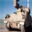

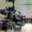

tensor([85, 85], device='cuda:0')
['tank', 'tank']


In [17]:
from torchvision.transforms.functional import to_pil_image
idx_to_class = {i:c for c,i in train.class_to_idx.items()}

print(idx)
display(to_pil_image(x[idx][0]))
display(to_pil_image(x[idx][1]))

print(y[idx])
print([idx_to_class[i] for i in y[idx].tolist()])
idx += 1

In [9]:
%%time 

for x, y in old_get_batches(data, "train", 128):
    y

CPU times: user 31.6 ms, sys: 152 µs, total: 31.7 ms
Wall time: 30.7 ms


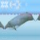

tensor(95, device='cuda:0')


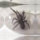

tensor(79, device='cuda:0')


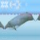

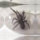

tensor([95, 79], device='cuda:0')


In [10]:
from torchvision.transforms.functional import to_pil_image

n = len(data["train"]["images"])

images_pairs = data["train"]["images"].reshape(n // 2, 2, 3, 40, 40)
labels_pairs  = data["train"]["targets"].reshape(n // 2, 2)

# show first and second image
display(to_pil_image(data["train"]["images"][0]))
print(data["train"]["targets"][0])
display(to_pil_image(data["train"]["images"][1]))
print(data["train"]["targets"][1])

# show first pair
display(to_pil_image(images_pairs[0][0]))
display(to_pil_image(images_pairs[0][1]))
print(labels_pairs[0])

## Implement siamese network

### Model definition

In [4]:
from torchvision.models import resnet18

In [40]:
from torch import nn


class SiameseNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = resnet18()
    def forward(self, x):
        x1, x2 = x[:, 0], x[:, 1]
        out1 = self.conv(x1) 
        out2 = self.conv(x2) 
        return out1, out2

In [6]:
x, y = next(get_batches(data, "train", 128))

In [45]:
net = SiameseNetwork()
net.to(device);

In [42]:
net

SiameseNetwork(
  (conv): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [46]:
net(x)

torch.Size([128, 2, 3, 32, 32])
torch.Size([128, 3, 32, 32]) torch.Size([128, 3, 32, 32])


(tensor([[-0.7721, -0.7750, -0.2479,  ..., -0.8757, -0.3601, -1.5296],
         [-0.7030, -1.1397, -1.0125,  ...,  0.0858,  1.4796, -1.5887],
         [ 0.2177, -0.5399, -0.1763,  ..., -0.1740, -0.5940, -0.3313],
         ...,
         [-0.5797, -0.2422, -1.5918,  ..., -1.9408, -0.5012, -1.9485],
         [ 0.6935, -0.1040, -0.1168,  ..., -1.0111,  0.1526, -1.4841],
         [ 0.0484,  0.0936, -0.9645,  ..., -0.8984, -1.2240, -0.8217]],
        device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[-1.3620, -1.0903, -0.1727,  ..., -1.3179, -0.8336, -2.7955],
         [ 0.4660, -1.0332, -0.4220,  ..., -0.9287,  0.1984, -1.7302],
         [ 0.7808, -0.6694, -0.7343,  ..., -0.2432, -0.4241, -0.7299],
         ...,
         [-0.4616, -1.2402, -1.6677,  ..., -0.2420, -0.6424, -1.1838],
         [ 0.0360,  0.0763, -1.6020,  ..., -0.3390,  0.7023, -0.8393],
         [ 0.3705,  1.0578, -0.1092,  ...,  0.5523, -0.8981, -0.8996]],
        device='cuda:0', grad_fn=<AddmmBackward0>))

### Classification Mechanism

## Train model

### Loss function

In [ ]:
def contrastive_loss(x, y):
    # x -> (bs, 2, ndim)
    # y -> (bs)

    

### Train and eval methods

### Incremental training